# A ParameterWithSetpoints Example with Dual Setpoints

This notebook explains how you can account for dual setpoints using `ParameterWithSetpoints`. The basics of writing drivers using `ParameterWithSetpoints` is covered in the notebook named [Simple Example of ParameterWithSetpoints](../Parameters/Simple-Example-of-ParameterWithSetpoints.ipynb).

In this example we consider a dummy instrument that can return a time trace or the discreet Fourier transform (magnitude square) of that trace. The setpoints are accounted for in an easy way.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


from qcodes import Measurement, initialise_or_create_database_at, load_or_create_experiment, load_by_id
from qcodes.instrument.base import Instrument, Parameter
from qcodes.instrument.parameter import ParameterWithSetpoints, expand_setpoints_helper
from qcodes.dataset.plotting import plot_dataset
import qcodes.utils.validators as vals

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/200219-33176-qcodes.log


In [2]:
def timetrace(npts: int, dt: float) -> np.ndarray:
    """
    A very realistic-looking signal
    """
    #freq = 10/(dt*npts)
    #decay = 1/(dt*npts)
    freq = 10
    decay = 1
    time = np.linspace(0, npts*dt, npts, endpoint=False)
    signal = np.exp(-decay*time)*np.sin(2*np.pi*freq*time)
    noise = 0.1*np.random.randn(npts)
    return signal + noise

In [3]:


class TimeTrace(ParameterWithSetpoints):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        
        return timetrace(npts, dt)
    

class Periodogram(ParameterWithSetpoints):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        
        tt = self.root_instrument.trace()
        
        return np.abs(np.fft.fft(tt))**2
        
        
class TimeAxis(Parameter):

    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        return np.linspace(0, dt*npts, npts, endpoint=False)

    
class FrequencyAxis(Parameter):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()

        return np.linspace(0, 1/dt, npts)
    
        
class OzzyLowScope(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
        
        self.add_parameter(name='npts',
                           initial_value=500,
                           label='Number of points',
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter(name='dt',
                           initial_value=1e-3,
                           label='Time resolution',
                           unit='s',
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter(name='time_axis',
                           label='Time',
                           unit='s',
                           vals=vals.Arrays(shape=(self.npts,)),
                           parameter_class=TimeAxis)
        
        self.add_parameter(name='freq_axis',
                           label='Frequency',
                           unit='Hz',
                           vals=vals.Arrays(shape=(self.npts,)),
                           parameter_class=FrequencyAxis)
        
        self.add_parameter(name='trace',
                           label='Signal',
                           unit='V',
                           vals=vals.Arrays(shape=(self.npts,)),
                           setpoints=(self.time_axis,),
                           parameter_class=TimeTrace)
        
        self.add_parameter(name='periodogram',
                           label='Periodogram',
                           unit='V^2/Hz',
                           vals=vals.Arrays(shape=(self.npts,)),
                           setpoints=(self.freq_axis,),
                           parameter_class=Periodogram)

In [4]:
osc = OzzyLowScope('osc')

In [5]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doND.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment(experiment_name='tutorial_exp', sample_name="no sample")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 898.72it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 514.01it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 336.92it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 329.59it/s]

tutorial_exp#no sample#1@/home/vsts/work/1/s/docs/examples/writing_drivers/tutorial_doND.db
-------------------------------------------------------------------------------------------

## Measurement 1: Time Trace

In [6]:
timemeas = Measurement()
timemeas.register_parameter(osc.trace)

osc.dt(0.001)

with timemeas.run() as datasaver:
    datasaver.add_result(*expand_setpoints_helper(osc.trace))
    
dataset = datasaver.dataset

Starting experimental run with id: 1. 


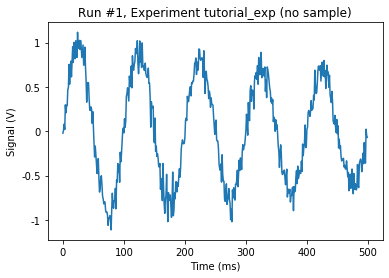

In [7]:
_ = plot_dataset(dataset)

In [8]:
osc.dt(0.01)  # make the trace 10 times longer

with timemeas.run() as datasaver:
    datasaver.add_result(*expand_setpoints_helper(osc.trace))
    
dataset = datasaver.dataset

Starting experimental run with id: 2. 


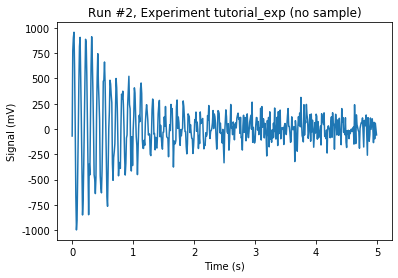

In [9]:
_ = plot_dataset(dataset)

## Measurement 2: Periodogram

In [10]:
freqmeas = Measurement()
freqmeas.register_parameter(osc.periodogram)

osc.dt(0.01)

with freqmeas.run() as datasaver:
    datasaver.add_result(*expand_setpoints_helper(osc.periodogram))
    
dataid = datasaver.dataset

Starting experimental run with id: 3. 


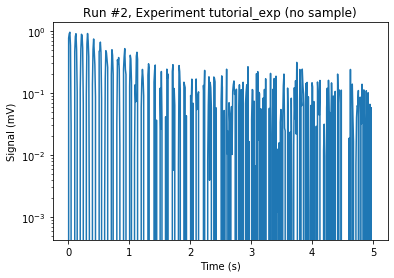

In [11]:
axs, cbax = plot_dataset(dataset)
aa = axs[0]
aa.set_yscale('log')

Just for the fun of it, let's make a measurement with the averaged periodogram.

In [12]:
no_of_avgs = 100

with freqmeas.run() as datasaver:
    
    temp_per = osc.periodogram()
    
    for _ in range(no_of_avgs-1):
        temp_per += osc.periodogram()
        
    datasaver.add_result((osc.periodogram, temp_per/no_of_avgs),
                         (osc.freq_axis, osc.freq_axis.get()))

dataset = datasaver.dataset

Starting experimental run with id: 4. 


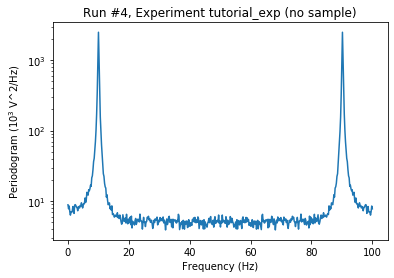

In [13]:
axs, cbax = plot_dataset(dataset)
aa = axs[0]
aa.set_yscale('log')

## Measurement 3: 2D Sweeping

In [14]:
meas = Measurement()
meas.register_parameter(osc.npts)
meas.register_parameter(osc.trace, setpoints=[osc.npts], paramtype='numeric')

with meas.run() as datasaver:

    osc.dt(0.001)
    
    for npts in [200, 400, 600, 800, 1000, 1200]:
        osc.npts(npts)
        datasaver.add_result(*expand_setpoints_helper(osc.trace),
                             (osc.npts, osc.npts()))
        
dataset = datasaver.dataset

Starting experimental run with id: 5. 


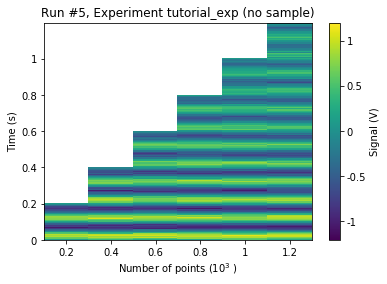

In [15]:
_ = plot_dataset(dataset)